**Function        : Visualization of AMET and OMET from reanalysis datasets**<br>
**Author          : Yang Liu**<br>
**Date            : 2021.09.26**<br>
**Last Update     : 2021.09.26**<br>
**Description     : The code aims to project the atmospheric/oceanic meridional energy transport on the map.**<br>
**Return Value    : PNGs**<br>
**Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging, iris, cartopy**<br>
variables         : <br>
                    AMET               Tera Watt<br>
                    OMET               Tera Watt<br>
                    Land-Sea Mask      mask<br>
**Caveat!!        : Spatial and temporal coverage**<br>
                    Atmosphere<br>
                    ERA-Interim 1979 - 2016<br>
                    Ocean<br>
                    ORAS4       1958 - 2014<br>
                    Data from 20N - 90N are taken into account!<br>

In [ ]:
import numpy as np
import os
import sys
from pathlib import Path
from netCDF4 import Dataset
# plots
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import iris
import iris.plot as iplt
# anime
import imageio

In [ ]:
################################   Input zone  ######################################
# specify data path
datapath = '/mnt/e/Reanalysis'
datapath_ERAI = Path(datapath, "era_model_subdaily_1979_2016_amet_FD.nc")
datapath_ORAS4 = Path(datapath, "oras_model_monthly_1958_2017_omet.nc")
maskpath_ORAS4 = Path(datapath, "mesh_mask.nc")

# specify output path
output_path = '/mnt/e/Reanalysis/frames'
output_path_anime = '/mnt/e/Reanalysis/anime'

# extract variables
dataset_ERAI = Dataset(datapath_ERAI)
dataset_ORAS4 = Dataset(datapath_ORAS4)
mesh_mask_ORAS4 = Dataset(maskpath_ORAS4)
# from 20N - 90N
AMET_ERAI = dataset_ERAI.variables['E_total'][:]/1000
OMET_ORAS4 = dataset_ORAS4.variables['E_total'][21:-1,:,180:,:]/1000 # start from 1979
#mask (surface mask only)
vmask_ORAS4 = mesh_mask_ORAS4.variables['vmask'][0,0,180:,:] # from 20N
# year
year_ERAI = dataset_ERAI.variables['year'][:]             # from 1979 to 2016
year_ORAS4 = dataset_ORAS4.variables['year'][21:-1]         # from 1958 to 2014
#latitude
latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_ORAS4 = dataset_ORAS4.variables['gphiv'][180:,:]
#longitude
longitude_ERAI = dataset_ERAI.variables['longitude'][:]
longitude_ORAS4 = dataset_ORAS4.variables['gphiv'][180:,:]

In [ ]:
print(year_ERAI)
print(AMET_ERAI.shape)
print(latitude_ERAI)
print(year_ORAS4)
print(latitude_ORAS4)

In [ ]:
latitude_AMET_ERAI = iris.coords.DimCoord(latitude_ERAI,standard_name='latitude',long_name='latitude',
                             var_name='lat',units='degrees')
longitude_AMET_ERAI = iris.coords.DimCoord(longitude_ERAI,standard_name='longitude',long_name='longitude',
                             var_name='lon',units='degrees')
cube_ERAI = iris.cube.Cube(AMET_ERAI[0,0,:,:],long_name='Atmospheric Meridional Energy Transport',
                           var_name='AMET',units='PW',dim_coords_and_dims=[(latitude_AMET_ERAI, 0), (longitude_AMET_ERAI, 1)])

TypeError: __init__() got an unexpected keyword argument 'facecolor'

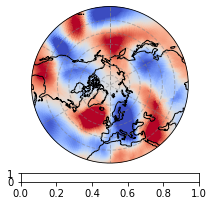

In [19]:
# sample plot
# figsize works for the size of the map, not the entire figure
fig1 = plt.figure(figsize=(4,3.6))

# suptitle is the title for the figure
#fig1.suptitle('Atmospheric Meridional Energy Transport in 1979 (year) 1 (month)',fontsize = 7,y=0.93)

# Set up axes, which means different view of maps
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Mercator(central_longitude=0, min_latitude=30, max_latitude=90))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# background image in cartopy(map style)
#ax.background_img(name='pop', resolution='high')
#ax.background_img(name='BM', resolution='low')

# Set limits of the map (choose area for plot)
#ax.set_global()
ax.set_extent([-180,180,20,90],ccrs.PlateCarree()) # East, West, South, Nouth

# adjust map by data coverage (function from matplotlib)
# could make the map an ellipse
#ax.set_aspect('auto')
ax.set_aspect('1')

# set ticks (overlap with gridlines)
#ax.set_xticks([-180, 120, 60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
#ax.set_yticks([30, 60], crs=ccrs.PlateCarree())

# Draw coastlines
ax.coastlines(resolution='110m', color='black', linewidth=1)

# map features
#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)
#ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# set gridlines and ticks
# options of crs and draw_labels only work for PlateCarree() and Mercator()
# for other axes, do not specify them
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5,linestyle='--')
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5,linestyle='--')
# set gridline details, only work for PlateCarree() and Mercator()
# switch of label locations
#gl.xlabels_top = False
#gl.xlabels_bottom = False
#gl.ylabels_left = False
#gl.ylabels_right = False
# use of formatter (fixed)
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
# specify label styles
#gl.xlabel_style = {'size': 6, 'color': 'gray'}
#gl.ylabel_style = {'size': 6, 'color': 'gray'}
# switch of lines
#gl.xlines = False
# specify the location of labels
#gl.ylocator = mticker.FixedLocator([30, 60])

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot with Iris plot pcolormesh
# camp is the colormap, vmin and vmax determines the minimum and maximum of data plotting range
cs = iplt.pcolormesh(cube_ERAI,cmap='coolwarm',vmin=-1.2,vmax=1.2)
#cs = iplt.contour(cube_ERAI,cmap='coolwarm',vmin=-1.0,vmax=1.0)
#cs = iplt.contourf(cube_ERAI,cmap='coolwarm',vmin=-1.0,vmax=1.0)
# setup colorbar, shrink is the horizontal size, pad determines the space between the map
cbar = fig1.colorbar(cs,extend='both',orientation='horizontal',shrink =0.8,pad=0.05,format="%.1f")
cbar.set_label('PW',size = 7)
cbar.set_ticks([-1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2])
cbar.ax.tick_params(labelsize = 7)

textstr = "1979 1"

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', edgecolor='white', alpha=0.6)

# place a text box in upper left in axes coords
ax.text(0.90, 0.98, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

# show and save plot
plt.tight_layout()
iplt.show()
fig1.savefig(Path(output_path, 'ERAI_NorthPole.jpg'), dpi = 200)
plt.close(fig1)

In [ ]:
# batch processing images for ERA-Interim
for i in year_ERAI:
    for j in np.arange(0,12,1):
        cube_ERAI = iris.cube.Cube(AMET_ERAI[i-1979,j,:,:],long_name='Atmospheric Meridional Energy Transport',
                           var_name='AMET',units='PW',dim_coords_and_dims=[(latitude_AMET_ERAI, 0), (longitude_AMET_ERAI, 1)])
        fig2 = plt.figure(figsize=(4,3.6))
        ax = plt.axes(projection=ccrs.NorthPolarStereo())
        ax.set_extent([-180,180,20,90],ccrs.PlateCarree())
        ax.set_aspect('1')
        ax.coastlines(resolution='110m', color='black', linewidth=1)
        gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5,linestyle='--')

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)  
        cs = iplt.pcolormesh(cube_ERAI,cmap='coolwarm',vmin=-1.2,vmax=1.2)
        cbar = fig2.colorbar(cs,extend='both',orientation='horizontal',shrink =0.8,pad=0.05,format="%.1f")
        cbar.set_label('PW',size = 7)
        cbar.set_ticks([-1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2])
        cbar.ax.tick_params(labelsize = 7)
        textstr = f"{i} {j+1}"
        props = dict(boxstyle='round', facecolor='white', edgecolor='white', alpha=0.7)
        ax.text(0.90, 0.98, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)
        plt.tight_layout()
        iplt.show()
        fig2.savefig(Path(output_path, f'AMET_ERAI_{i}y_{j+1}m_np.png'), dpi = 200, transparent=False)
        plt.close(fig2)

In [18]:
# generate animation
index_plot = len(year_ERAI) * 12
target_folder = "northpole" # pure or date
#For long movie (save memory)
with imageio.get_writer(Path(output_path_anime, f'amet_era_{target_folder}_np.gif'), mode='I',duration=0.5) as writer:
    for i in year_ERAI:
        print(f"year {i}")
        for j in np.arange(0,12,1):
            images = imageio.imread(Path(output_path, 'atmos', target_folder, f'AMET_ERAI_{i}y_{j+1}m_np.png'))
            writer.append_data(images)
writer.close()

year 1979
year 1980
year 1981
year 1982
year 1983
year 1984
year 1985
year 1986
year 1987
year 1988
year 1989
year 1990
year 1991
year 1992
year 1993
year 1994
year 1995
year 1996
year 1997
year 1998
year 1999
year 2000
year 2001
year 2002
year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
